<a href="https://colab.research.google.com/github/sandana123kri/sandana123kri-Deep_learning_tensorflow/blob/main/gradient_descent_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv("insurance_data.csv")
df.head()

,age,affordibility,bought_insurance
0,22,1,0
1,25,0,0
2,47,1,1
3,52,0,0
4,46,1,1


Train test split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['age','affordibility']],df.bought_insurance,test_size=0.2)

Preprocessing: Scale the data so that both age and affordibility comes under same scaling range.

In [5]:
X_train_scaled=X_train.copy()
X_train_scaled['age']=X_train_scaled['age']/100
X_test_scaled=X_test.copy()
X_test_scaled['age']=X_test_scaled['age']/100

Model Building: First build a model in keras/tensorflow and see what weights and bias values it comes up with. We will than try to reproduce same weights and bias in our plain python implementation of gradient descent. Below is the architecture of our simple neural network

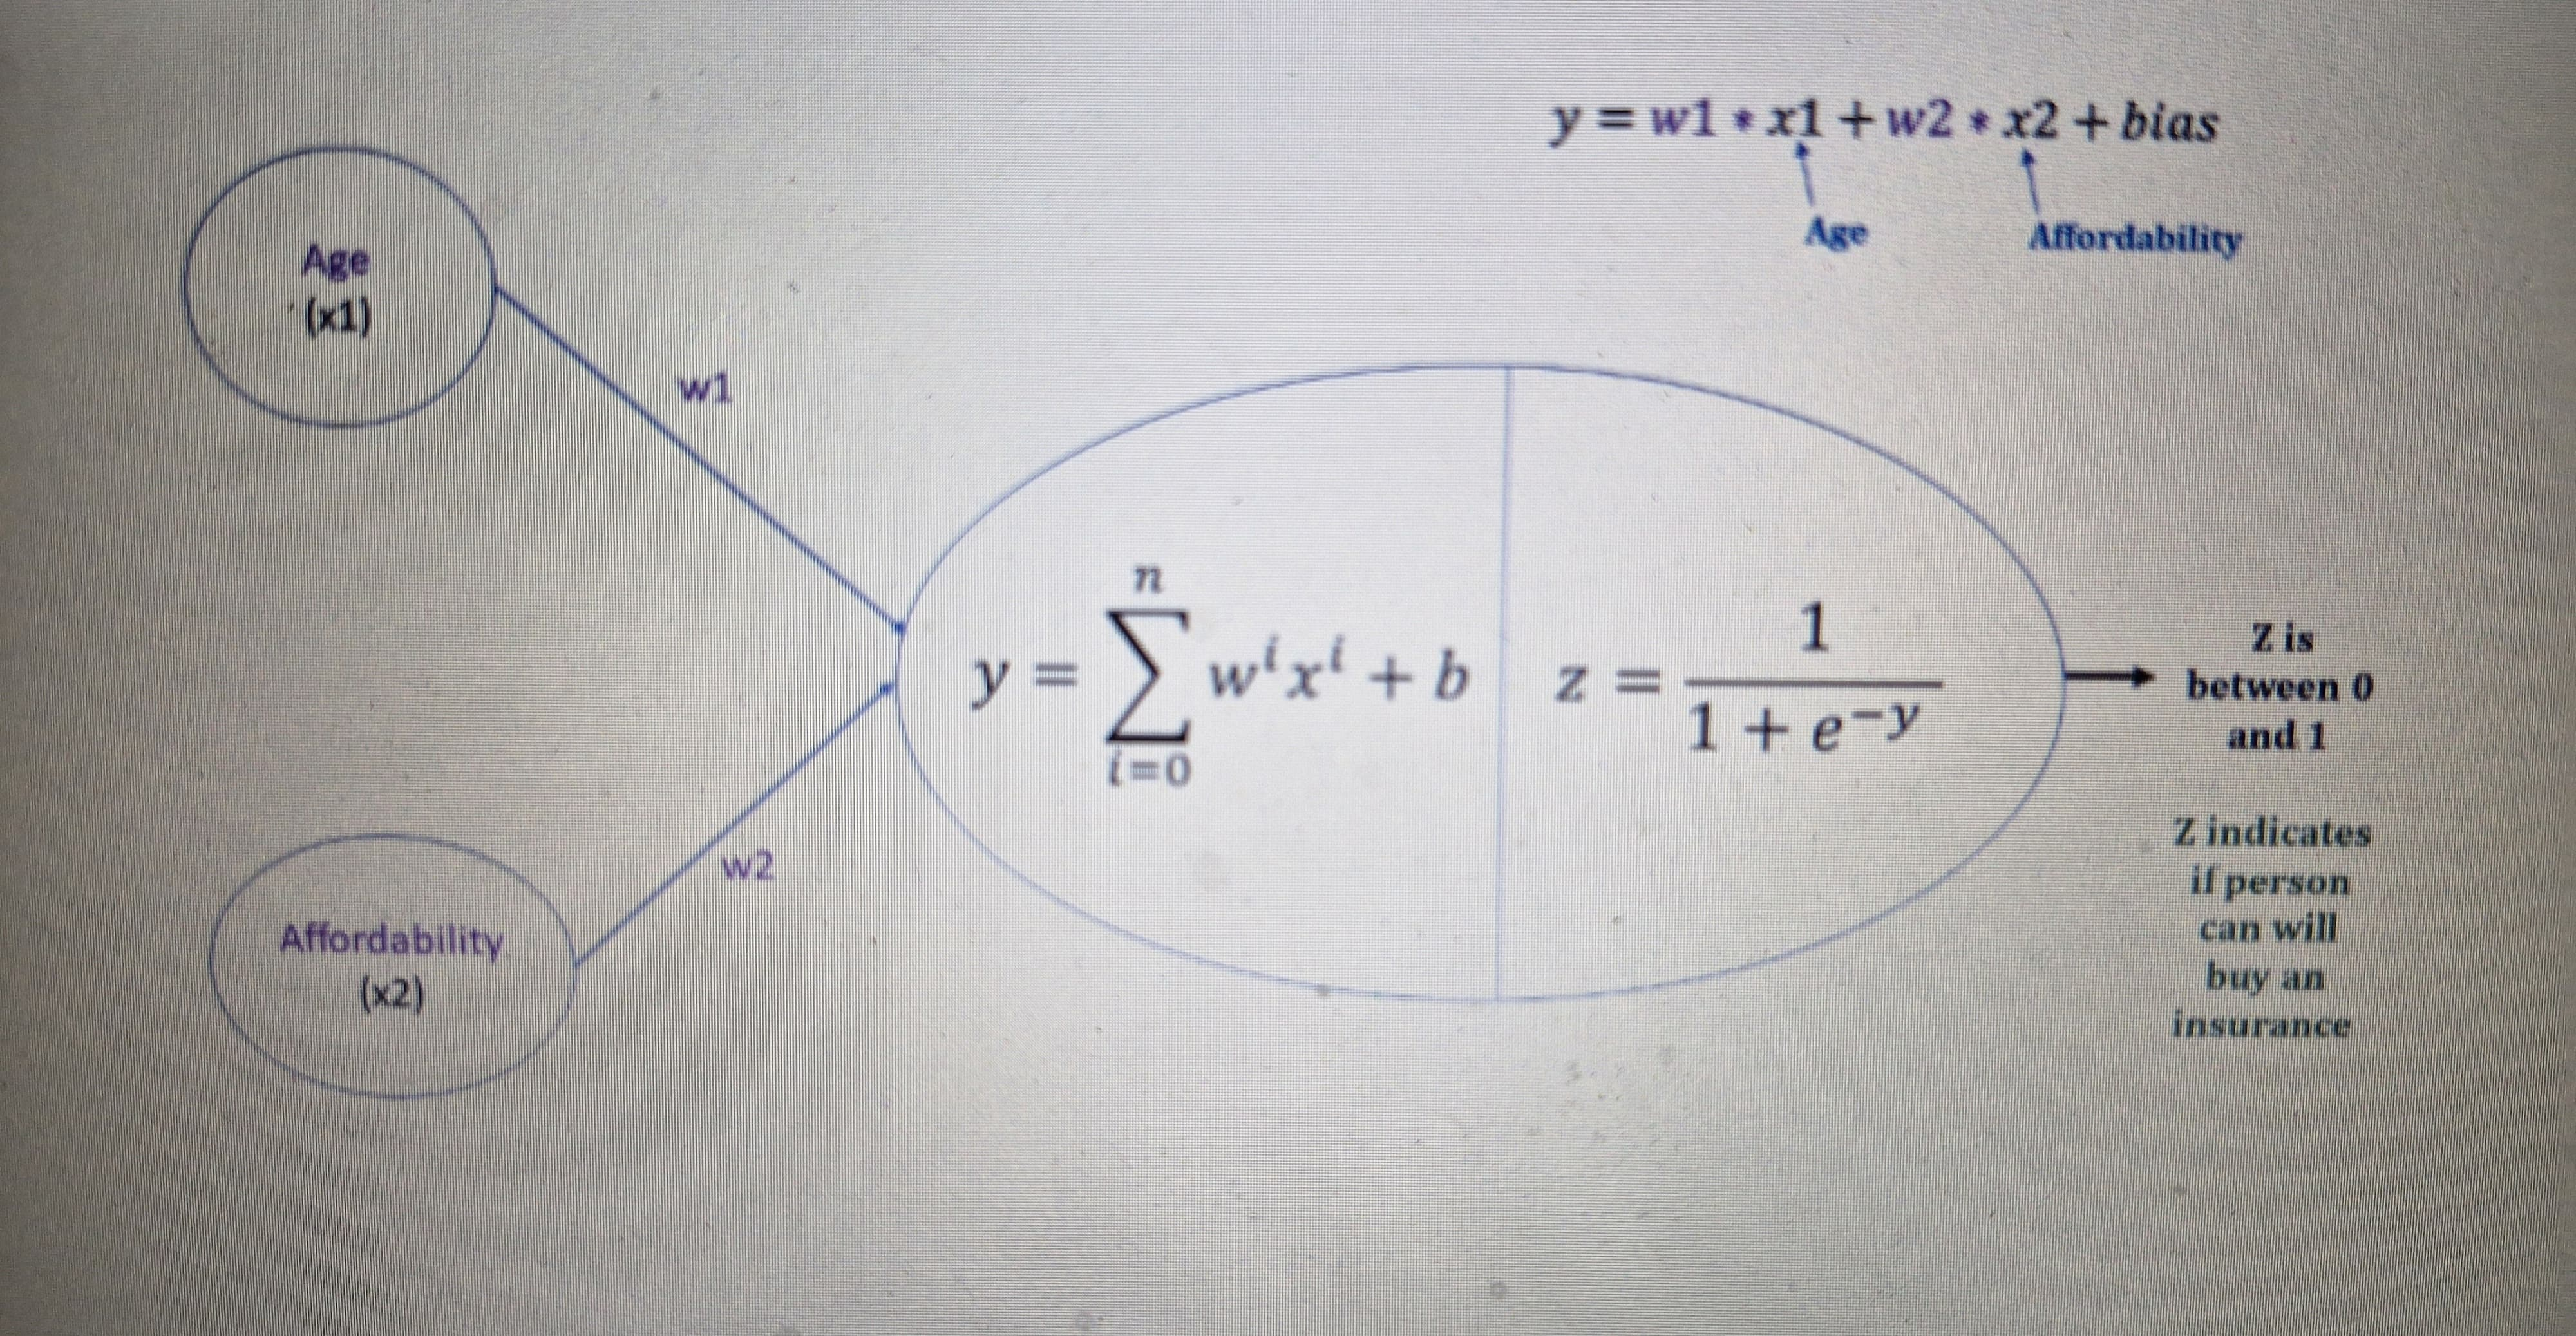

In [6]:
model=keras.Sequential([
    keras.layers.Dense(1,input_shape=(2,),activation='sigmoid',kernel_initializer='ones',bias_initializer='zeros')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train_scaled,y_train,epochs=5000)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7273 - loss: 0.5018
Epoch 2502/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7273 - loss: 0.5017
Epoch 2503/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7273 - loss: 0.5017
Epoch 2504/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7273 - loss: 0.5017
Epoch 2505/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7273 - loss: 0.5016
Epoch 2506/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7273 - loss: 0.5016
Epoch 2507/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7273 - loss: 0.5016
Epoch 2508/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7273 - loss: 0.5015
Epoch 2509/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7273 - loss: 0.5015
Epoch 2510/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7273 - loss: 0.5015
Epoch 2511/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7273 - loss: 0.5

Evaluate the model on test data

In [7]:
model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8333 - loss: 0.4183


[0.4183429181575775, 0.8333333134651184]

In [8]:
model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[0.21763396],
       [0.76126295],
       [0.605479  ],
       [0.33938804],
       [0.15554596],
       [0.38004723]], dtype=float32)

In [9]:
y_test

,bought_insurance
21,0
14,1
6,0
19,0
18,0
20,0



now get the value of weight and bias from the model



In [10]:
coef, intercept= model.get_weights()

In [11]:
coef,intercept

(array([[5.8891563],
        [1.0846181]], dtype=float32),
 array([-2.8106887], dtype=float32))

In [12]:
def sigmoid(x):
        import math
        return 1 / (1 + math.exp(-x))
sigmoid(18)

0.9999999847700205

Instead of model.predict, write our own prediction function that uses w1,w2 and bias

In [13]:
def prediction_function(age, affordibility):
    weighted_sum = coef[0]*age + coef[1]*affordibility + intercept
    return sigmoid(weighted_sum)

prediction_function(.47, 1)

/tmp/ipython-input-396317115.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 / (1 + math.exp(-x))


0.739203515122076

Now we start implementing gradient descent in plain python. Again the goal is to come up with same w1, w2 and bias that keras model calculated. We want to show how keras/tensorflow would have computed these values internally using gradient descent

First write couple of helper routines such as sigmoid and log_loss

In [14]:
def log_loss(y_true, y_predicted):
    epsilon = 1e-15
    y_predicted_new = [max(i,epsilon) for i in y_predicted]
    y_predicted_new = [min(i,1-epsilon) for i in y_predicted_new]
    y_predicted_new = np.array(y_predicted_new)
    return -np.mean(y_true*np.log(y_predicted_new)+(1-y_true)*np.log(1-y_predicted_new))

In [15]:
def sigmoid_numpy(X):
   return 1/(1+np.exp(-X))

sigmoid_numpy(np.array([12,0,1]))

array([0.99999386, 0.5       , 0.73105858])

In [16]:
def gradient_descent(age, affordability, y_true, epochs, loss_thresold):
    w1 = w2 = 1
    bias = 0
    rate = 0.5
    n = len(age)
    for i in range(epochs):
        weighted_sum = w1 * age + w2 * affordability + bias
        y_predicted = sigmoid_numpy(weighted_sum)
        loss = log_loss(y_true, y_predicted)

        w1d = (1/n)*np.dot(np.transpose(age),(y_predicted-y_true))
        w2d = (1/n)*np.dot(np.transpose(affordability),(y_predicted-y_true))

        bias_d = np.mean(y_predicted-y_true)
        w1 = w1 - rate * w1d
        w2 = w2 - rate * w2d
        bias = bias - rate * bias_d

        print (f'Epoch:{i}, w1:{w1}, w2:{w2}, bias:{bias}, loss:{loss}')

        if loss<=loss_thresold:
            break

    return w1, w2, bias

In [17]:
gradient_descent(X_train_scaled['age'],X_train_scaled['affordibility'],y_train,1000, 0.4631)

Epoch:0, w1:0.9882015299985963, w2:0.9561067708528698, bias:-0.0788079135154839, loss:0.6497669161566292
Epoch:1, w1:0.9806438326236137, w2:0.9196774104677768, bias:-0.1474053269604702, loss:0.6343836311989164
Epoch:2, w1:0.976896172716103, w2:0.8900159258673073, bias:-0.2068505542387777, loss:0.6230995583018362
Epoch:3, w1:0.9764942421269286, w2:0.8663352114259167, bias:-0.25826837868227276, loss:0.6149071457420155
Epoch:4, w1:0.9789750673258211, w2:0.847827767313141, bias:-0.30276991604810244, loss:0.6089745414001707
Epoch:5, w1:0.9839016022363004, w2:0.8337172493995938, bias:-0.34139719307588356, loss:0.6046518194258469
Epoch:6, w1:0.990877378094956, w2:0.823290671025387, bias:-0.3750909887660031, loss:0.6014526945657264
Epoch:7, w1:0.999553179784646, w2:0.8159146579924695, bias:-0.4046770305943813, loss:0.599025397862531
Epoch:8, w1:1.0096281209035673, w2:0.811040238317802, bias:-0.4308648997162672, loss:0.5971220502927783
Epoch:9, w1:1.0208472277899137, w2:0.808200289844373, bias:

(np.float64(4.804561161737408),
 np.float64(1.0808122481823796),
 np.float64(-2.3541018378314353))

In [18]:
coef, intercept

(array([[5.8891563],
        [1.0846181]], dtype=float32),
 array([-2.8106887], dtype=float32))

This shows that in the end we were able to come up with same value of w1,w2 and bias using a plain python implementation of gradient descent function